## **TD : Analyse de séries temporelles**

Les séries temporelles sont un type particulier de données qui représentent des suites de valeurs ordonnées dans le temps. L’horodatage des données peut être  explicite (une date est donnée pour chaque valeur) ou implicite (c’est l’ordre d’apparition des données qui est pris en  compte).

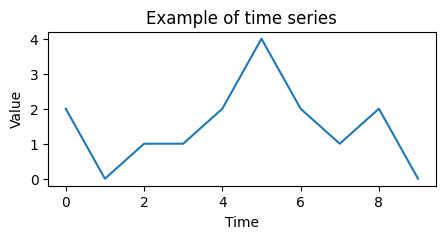

In [2]:
import matplotlib.pyplot as plt

x = [2, 0, 1, 1, 2, 4, 2, 1, 2, 0]

plt.figure(figsize=(5,2))
plt.plot([i for i in range(0,len(x))],x)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Example of time series')
plt.show()

Ces données peuvent par exemple représenter l'évolution des valeurs données par un capteur dans le temps (par exemple la température ou la pression), un électrocardiogramme, ou encore un son.

La classification de séries temporelles consiste à affecter une classe à une donnée en fonction de ses caractéristiques. Des électrocardiogrammes de patients peuvent par exemple être classés "normaux" ou "anormaux" en fonction de leurs caractéristiques.

Dans ce contexte, l'algorithme du plus proche voisin est souvent utilisé afin de classifier des séries temporelles. Étant donnée une série temporelle à classer, cet algorithme consiste à chercher la série temporelle "la plus proche" dans un ensemble de séries temporelles dont on connaît la classe. On possède ainsi deux ensembles de données, un premier, appelé "train" composé de séries temporelles dont la classe est connue, et une second, appelé "test" dont nous cherchons à prédire la classe.

 ### Lecture des données :

La première étape afin d'effectuer de la classification de séries temporelles  consiste à lire les données. Executer le bloc ci-dessous afin de récupérer les quatre jeux de données que nous allons utiliser dans ce TD.

In [3]:
# download the data
!wget -nc https://germain-forestier.info/dataset/timeseries.zip
!unzip timeseries.zip

--2025-11-12 13:27:02--  https://germain-forestier.info/dataset/timeseries.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving germain-forestier.info (germain-forestier.info)... 213.186.33.19
Connecting to germain-forestier.info (germain-forestier.info)|213.186.33.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 875796 (855K) [application/zip]
Saving to: ‘timeseries.zip’

timeseries.zip      100%[===================>] 855.27K  --.-KB/s    in 0.05s   

2025-11-12 13:27:03 (17.2 MB/s) - ‘timeseries.zip’ saved [875796/875796]

Archive:  timeseries.zip
   creating: 50words/
  inflating: 50words/50words_TEST    
  inflating: 50words/50words_TRAIN   
   creating: Coffee/
  inflating: Coffee/Coffee_TEST      
  inflating: Coffee/Coffee_TRAIN     
   creating: ECG200/
  inflating: ECG200/ECG200_TEST      
  inflating: ECG200/ECG200_TRAIN     
   creating: Gun_Point/
  inflating: Gun_Point/Gun_Point_TEST  
  inflating: Gun_Point/Gun_Point_TRAIN  

* [50words](http://timeseriesclassification.com/description.php?Dataset=FiftyWords) : représente le contour de mots
* [Coffee](http://timeseriesclassification.com/description.php?Dataset=Coffee) : représente le spectrographe de grain de café
* [ECG200](http://timeseriesclassification.com/description.php?Dataset=ECG200) : représente des électrocardiogrammes
* [GunPoint](http://timeseriesclassification.com/description.php?Dataset=GunPoint) : représente des mouvements

<img width="300px" src="http://timeseriesclassification.com/images/datasets/GunPoint.png" />

*Illustration du mouvement ”Gun” du jeu de données GunPoint. © [Eamonn Keogh](https://www.cs.ucr.edu/~eamonn/)*

Pour chaque jeu de données, les fichiers `TRAIN` et `TEST` contiennent respectivement les séries temporelles connues (`TRAIN`) et à classer (`TEST`).

### Chargement des données :

* Choisir un premier jeu de données (par exemple `Gun_Point`)
* Charger les données à l'aide de `pandas` (fonction `read_csv`)
* La première colonne correspond à la classe
* Décomposer les données (fichiers `TRAIN` et `TEST`) en `X_train,y_train,X_test,y_test`

In [4]:
# Votre code ici
import pandas as pd

df_train = pd.read_csv("Gun_Point/Gun_Point_TRAIN")
print(df_train.head())

   2  -0.64789  -0.64199  -0.63819  -0.63826  -0.63835  -0.6387  -0.64305  \
0  2  -0.64443  -0.64540  -0.64706  -0.64749  -0.64691 -0.64388  -0.63973   
1  1  -0.77835  -0.77828  -0.77715  -0.77768  -0.77590 -0.77242  -0.76546   
2  1  -0.75006  -0.74810  -0.74616  -0.74593  -0.74377 -0.74381  -0.74521   
3  2  -0.59954  -0.59742  -0.59927  -0.59826  -0.59758 -0.59130  -0.58902   
4  2  -0.54774  -0.55366  -0.55719  -0.55960  -0.56431 -0.56822  -0.57197   

   -0.64377  -0.64505  ...  -0.63926  -0.63972  -0.63973  -0.64018  -0.63923  \
0  -0.63809  -0.63530  ...  -0.64114  -0.64143  -0.63927  -0.63780  -0.63768   
1  -0.76228  -0.76375  ...  -0.72206  -0.71871  -0.71353  -0.71002  -0.70413   
2  -0.74508  -0.74573  ...  -0.72167  -0.72466  -0.72923  -0.72894  -0.72783   
3  -0.58753  -0.58546  ...  -0.64404  -0.64388  -0.64574  -0.64646  -0.64646   
4  -0.57583  -0.57735  ...  -0.70694  -0.70476  -0.70390  -0.70416  -0.70541   

   -0.63939  -0.64023  -0.64043  -0.63867  -0.63866  
0 

 #### Corrigé :

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import math

# loading the data
df_test = pd.read_csv('Gun_Point/Gun_Point_TEST', sep=',', header=None)
df_train = pd.read_csv('Gun_Point/Gun_Point_TRAIN', sep=',', header=None)

X_train = df_train.iloc[:,1:].values
y_train = df_train[0].values

X_test = df_test.iloc[:,1:].values
y_test = df_test[0].values

 ### Définiton de la distance euclidienne :

 * Ecrire une fonction Python qui calcule la distance euclidienne entre deux séries temporelles, c'est-à-dire deux lignes des tableaux `X_train` ou `X_test`

In [ ]:
# Votre code ici

 #### Corrigé :

In [ ]:
# euclidean distance
def eucdist(a, b):
    dist = 0
    for index, x in np.ndenumerate(a):
        dist += (b[index] - x)**2
    return math.sqrt(dist)

a = X_train[0,:]
b = X_train[1,:]

d = eucdist(a,b)
print('dist(a,b)= '+str(round(d,2)))

dist(a,b)= 4.62


 ### Visualisation des données :

 * Utiliser `matplotlib` afin de visualser les séries de `X_train`
 * Les séries de la même classe doivent avoir la même couleur

In [ ]:
# Votre code ici

 #### Corrigé :

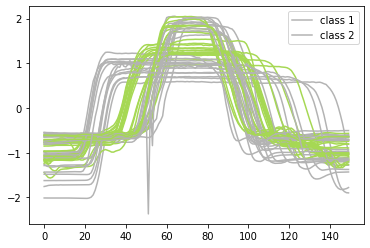

In [ ]:
# matplotlib
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap("Set2", len(np.unique(y_train))+1)

for i,ts in enumerate(X_train):
  plt.plot([i for i in range(0,len(ts))],ts,c=cmap(y_train[i]))

plt.legend(['class 1', 'class 2'])
plt.show()

 ### 1-plus-proche-voisin euclidien :

 * Ecrire une double boucle qui recherche pour chaque série du test la série du train qui est la plus proche
 * Compter le nombre d'erreurs réalisé par l'algorithme
 * Afficher la précision de l'algorithme (nombre d'erreurs / nombre d'éléments du test)
 * Vos résultats doivent être identiques aux résultats présentés sur le site de [l'UCR Archive](https://www.cs.ucr.edu/~eamonn/time_series_data/) colonne ”1-NN Euclidean Distance”
 * Penser à tester votre code avec les 4 jeux de données

In [ ]:
# Votre code ici

 #### Corrigé :

In [ ]:
error = 0
for i in tqdm(range(0,X_test.shape[0])):
    series = X_test[i,:]
    minDist = float('inf')
    index = -1
    for j in range(0,X_train.shape[0]):
        tmp = X_train[j,:]
        dist = eucdist(series, tmp)
        if(dist < minDist):
            minDist = dist
            index = j
    if y_test[i] != y_train[index]:
        error = error + 1

print('\n Error rate: '+str(round(error / X_test.shape[0],3)))

  0%|          | 0/150 [00:00<?, ?it/s]


 Error rate: 0.087


 ### Dynamic Time Warping (DTW) :

[Dynamic Time Warping (DTW)](https://fr.wikipedia.org/wiki/D%C3%A9formation_temporelle_dynamique) est un algorithme de comparaison de séries temporelles prenant en compte les possibles déformations temporelles entre les données (ce qui n'est pas le cas de la distance euclidienne).
Cet algorithme permet très souvent d'obtenir de meilleurs résultats que la distance euclidienne sur des données réelles, car celles-ci contiennent souvent des distorsions temporelles.
De plus, DTW permet également de comparer des séries temporelles n'ayant pas la même longueur.
DTW est calculé à l'aide d'un algorithme de programmation dynamique qui remplis récursivement une matrice d'alignement.

Algorithme de calcul de DTW :

```
int dtw(s: array [0..n], t: array [0..m]) {
    DTW := array [0..n+1, 0..m+1]
    
    for i := 0 to n
        for j := 1 to m
            DTW[i, j] := infinity
    DTW[0, 0] := 0
    
    for i := 1 to n
        for j := 1 to m
            cost := d(s[i-1], t[j-1])
            DTW[i, j] := cost + minimum(DTW[i-1, j  ],    // insertion
                                        DTW[i  , j-1],    // deletion
                                        DTW[i-1, j-1])    // match
    
    return sqrt(DTW[n, m])
}
```

* Ecrire une fonction Python qui calcule la cout de l'alignement entre deux séries à l'aide de l'algorithme DTW
* Votre fonction doit renvoyer le coût de l'alignement ainsi que la matrice de coût utilisée par l'algorithme
* Ecrire l'algorithme du 1-plus-proche-voisin en utilisant DTW à la place de la distance euclidienne
* Comparer les précisions obtenues entre avec les deux mesures (euclidien et DTW)
* ⚠ **Attention** : le coût algorithme de DTW étant beaucoup plus important que pour la distance euclidienne (quadratique vs. linéaire), la classification peut prendre du temps. Vous pouvez monitorer la progression à l'aide du package `tqdm`

In [ ]:
# Votre code ici

 #### Corrigé :

In [ ]:
def dtw(s1, s2):
    DTW = np.zeros((len(s1)+1,len(s2)+1))
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, DTW.shape[0]):
        for j in range(1, DTW.shape[1]):
            dist= (s1[i-1]-s2[j-1])**2
            DTW[i, j] = dist + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    return math.sqrt(DTW[len(s1), len(s2)]), DTW

In [ ]:
error = 0
for i in tqdm(range(0,X_test.shape[0])):
    series = X_test[i,:]
    minDist = float('inf')
    index = -1
    for j in range(0,X_train.shape[0]):
        tmp = X_train[j,:]
        dist, mtx  = dtw(series, tmp)
        if(dist < minDist):
            minDist = dist
            index = j
    if y_test[i] != y_train[index]:
        error = error + 1

print('\n Error rate: '+str(round(error / X_test.shape[0],3)))

  0%|          | 0/150 [00:00<?, ?it/s]


 Error rate: 0.093


 ### Visualisation de la matrice de coût :

* Visualiser la matrice de coût (`mtx`) à l'aide de `plt.imshow()`



In [ ]:
a = X_train[0,:]
b = X_train[1,:]

d, mtx = dtw(a,b)
print('dist(a,b)= '+str(round(d,2)))

dist(a,b)= 0.43


In [ ]:
# Votre code ici

 #### Corrigé :

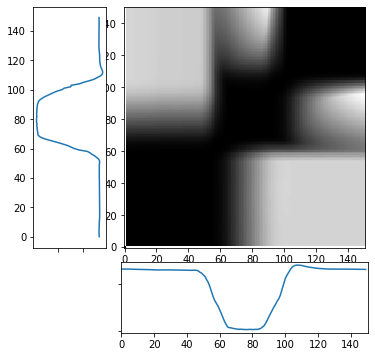

In [ ]:
import matplotlib.pyplot as plt

def plot_cost_matrix(a,b,mtx):
  fig = plt.figure(figsize=(6, 6))
  grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
  main_ax = fig.add_subplot(grid[:-1, 1:])
  y_ts = fig.add_subplot(grid[:-1, 0], xticklabels=[])
  x_ts = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

  main_ax.imshow(mtx, origin='lower', cmap='gray', interpolation='nearest')

  y_ts.plot(a,[i for i in range(0,len(ts))])
  y_ts.invert_xaxis()

  x_ts.plot([i for i in range(0,len(ts))],b)
  x_ts.invert_yaxis()
  plt.show()

plot_cost_matrix(a,b,mtx)

### Prise en compte des contraintes :

Il peut arriver dans certains cas qu’il soit intéressant de limiter la quantité de distorsion allouée par l’algorithme DTW. Dans ce cas, on ajoute un paramètre supplémentaire, appelé w, qui limite le parcours du chemin d’alignement. Dans ce cas, la matrice d’alignement ne sera pas entièrement calculée.

Voici le pseudo-code de DTW avec la contrainte `w` :


```
int dtw(s: array [0..n], t: array [0..m], w: int) {
    DTW := array [0..n+1, 0..m+1]
    
    for i := 0 to n
        for j := 1 to m
            DTW[i, j] := infinity
    DTW[0, 0] := 0
    
    for i := 1 to n
        for j := max(1, i-w) to min(m, i+w)
            cost := d(s[i-1], t[j-1])
            DTW[i, j] := cost + minimum(DTW[i-1, j  ],    // insertion
                                        DTW[i  , j-1],    // deletion
                                        DTW[i-1, j-1])    // match
    
    return sqrt(DTW[n, m])
}
```

In [ ]:
# Votre code ici

 #### Corrigé :

In [ ]:
def dtw(s1, s2, w):
    DTW = np.zeros((len(s1)+1,len(s2)+1))
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, DTW.shape[0]):
        for j in range(max(1,i-w), min(DTW.shape[1],i+w)):
            dist= (s1[i-1]-s2[j-1])**2
            DTW[i, j] = dist + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    return math.sqrt(DTW[len(s1), len(s2)]), DTW

In [ ]:
error = 0
for i in tqdm(range(1,X_test.shape[0])):
    series = X_test[i,:]
    minDist = float('inf')
    index = -1
    for j in range(1,X_train.shape[0]):
        tmp = X_train[j,:]
        dist, mtx  = dtw(series, tmp, 20)
        if(dist < minDist):
            minDist = dist
            index = j
    if y_test[i] != y_train[index]:
        error = error + 1

print('\n Error rate: '+str(round(error / X_test.shape[0],3)))

  0%|          | 0/149 [00:00<?, ?it/s]


 Error rate: 0.54


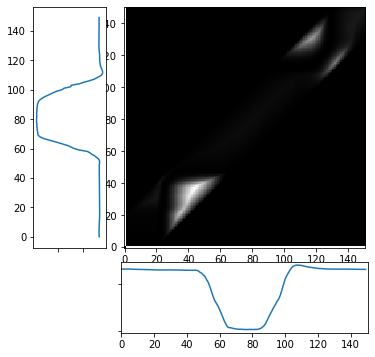

In [ ]:
plot_cost_matrix(a,b,mtx)